## Parameter Estimation of Lotka-Volterra Equation using DiffEqBayes.jl

In [1]:
using DiffEqBayes
using Distributions
using DifferentialEquations
using Plots
using Turing
using DiffEqMonteCarlo,ContinuousTransformations

[Turing]: AD chunk size is set as 40



ArgumentError: Module Hiccup not found in current path.
Run `Pkg.add("Hiccup")` to install the Hiccup package.


In [2]:
gr(fmt=:png)

Plots.GRBackend()

#### Initializing the problem

In [3]:
f = @ode_def_nohes LotkaVolterraTest begin
    dx = a*x - b*x*y
    dy = -c*y + d*x*y
end a b c d

(::LotkaVolterraTest) (generic function with 9 methods)

In [4]:
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1,0]

5-element Array{Float64,1}:
 1.5
 1.0
 3.0
 1.0
 0.0

In [5]:
prob = ODEProblem(f,u0,tspan,p)
@time sol = solve(prob,Tsit5())

  5.874239 seconds (3.29 M allocations: 185.293 MiB, 1.78% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Array{Float64,1}:
  0.0      
  0.0776085
  0.232645 
  0.429118 
  0.679082 
  0.944406 
  1.26746  
  1.61929  
  1.98697  
  2.26409  
  2.51254  
  2.74682  
  3.038    
  ⋮        
  6.45576  
  6.7805   
  7.17104  
  7.58486  
  7.97806  
  8.48316  
  8.71924  
  8.9492   
  9.20018  
  9.43802  
  9.7118   
 10.0      
u: 34-element Array{Array{Float64,1},1}:
 [1.0, 1.0]         
 [1.04549, 0.857668]
 [1.17587, 0.63946] 
 [1.41968, 0.456996]
 [1.87672, 0.324733]
 [2.58825, 0.263362]
 [3.86071, 0.279446]
 [5.75081, 0.522006]
 [6.81498, 1.91778] 
 [4.39301, 4.19467] 
 [2.10088, 4.31696] 
 [1.24228, 3.10738] 
 [0.958273, 1.76616]
 ⋮                  
 [0.952206, 1.43835]
 [1.10046, 0.752663]
 [1.59911, 0.390319]
 [2.61424, 0.26417] 
 [4.24104, 0.305121]
 [6.79111, 1.1345]  
 [6.26541, 2.74165] 
 [3.78084, 4.43114] 
 [1.81645, 4.06409] 
 [1.14652, 2.79124] 
 [0.9558, 1.6236]   
 [1.03376, 0.90

#### We take the solution data obtained and add noise to it to obtain data for using in the Bayesian Inference of the parameters

In [6]:
t = collect(linspace(1,10,10))
sig = 0.49
data = convert(Array, VectorOfArray([(sol(t[i]) + sig*randn(2)) for i in 1:length(t)]))

2×10 Array{Float64,2}:
 2.97456   7.50721  0.736527  1.1996   …  3.72951   3.50751  0.556975
 0.368419  2.54733  1.7529    1.06577     0.741715  3.82068  1.26793 

#### Plots of the actual data and generated data


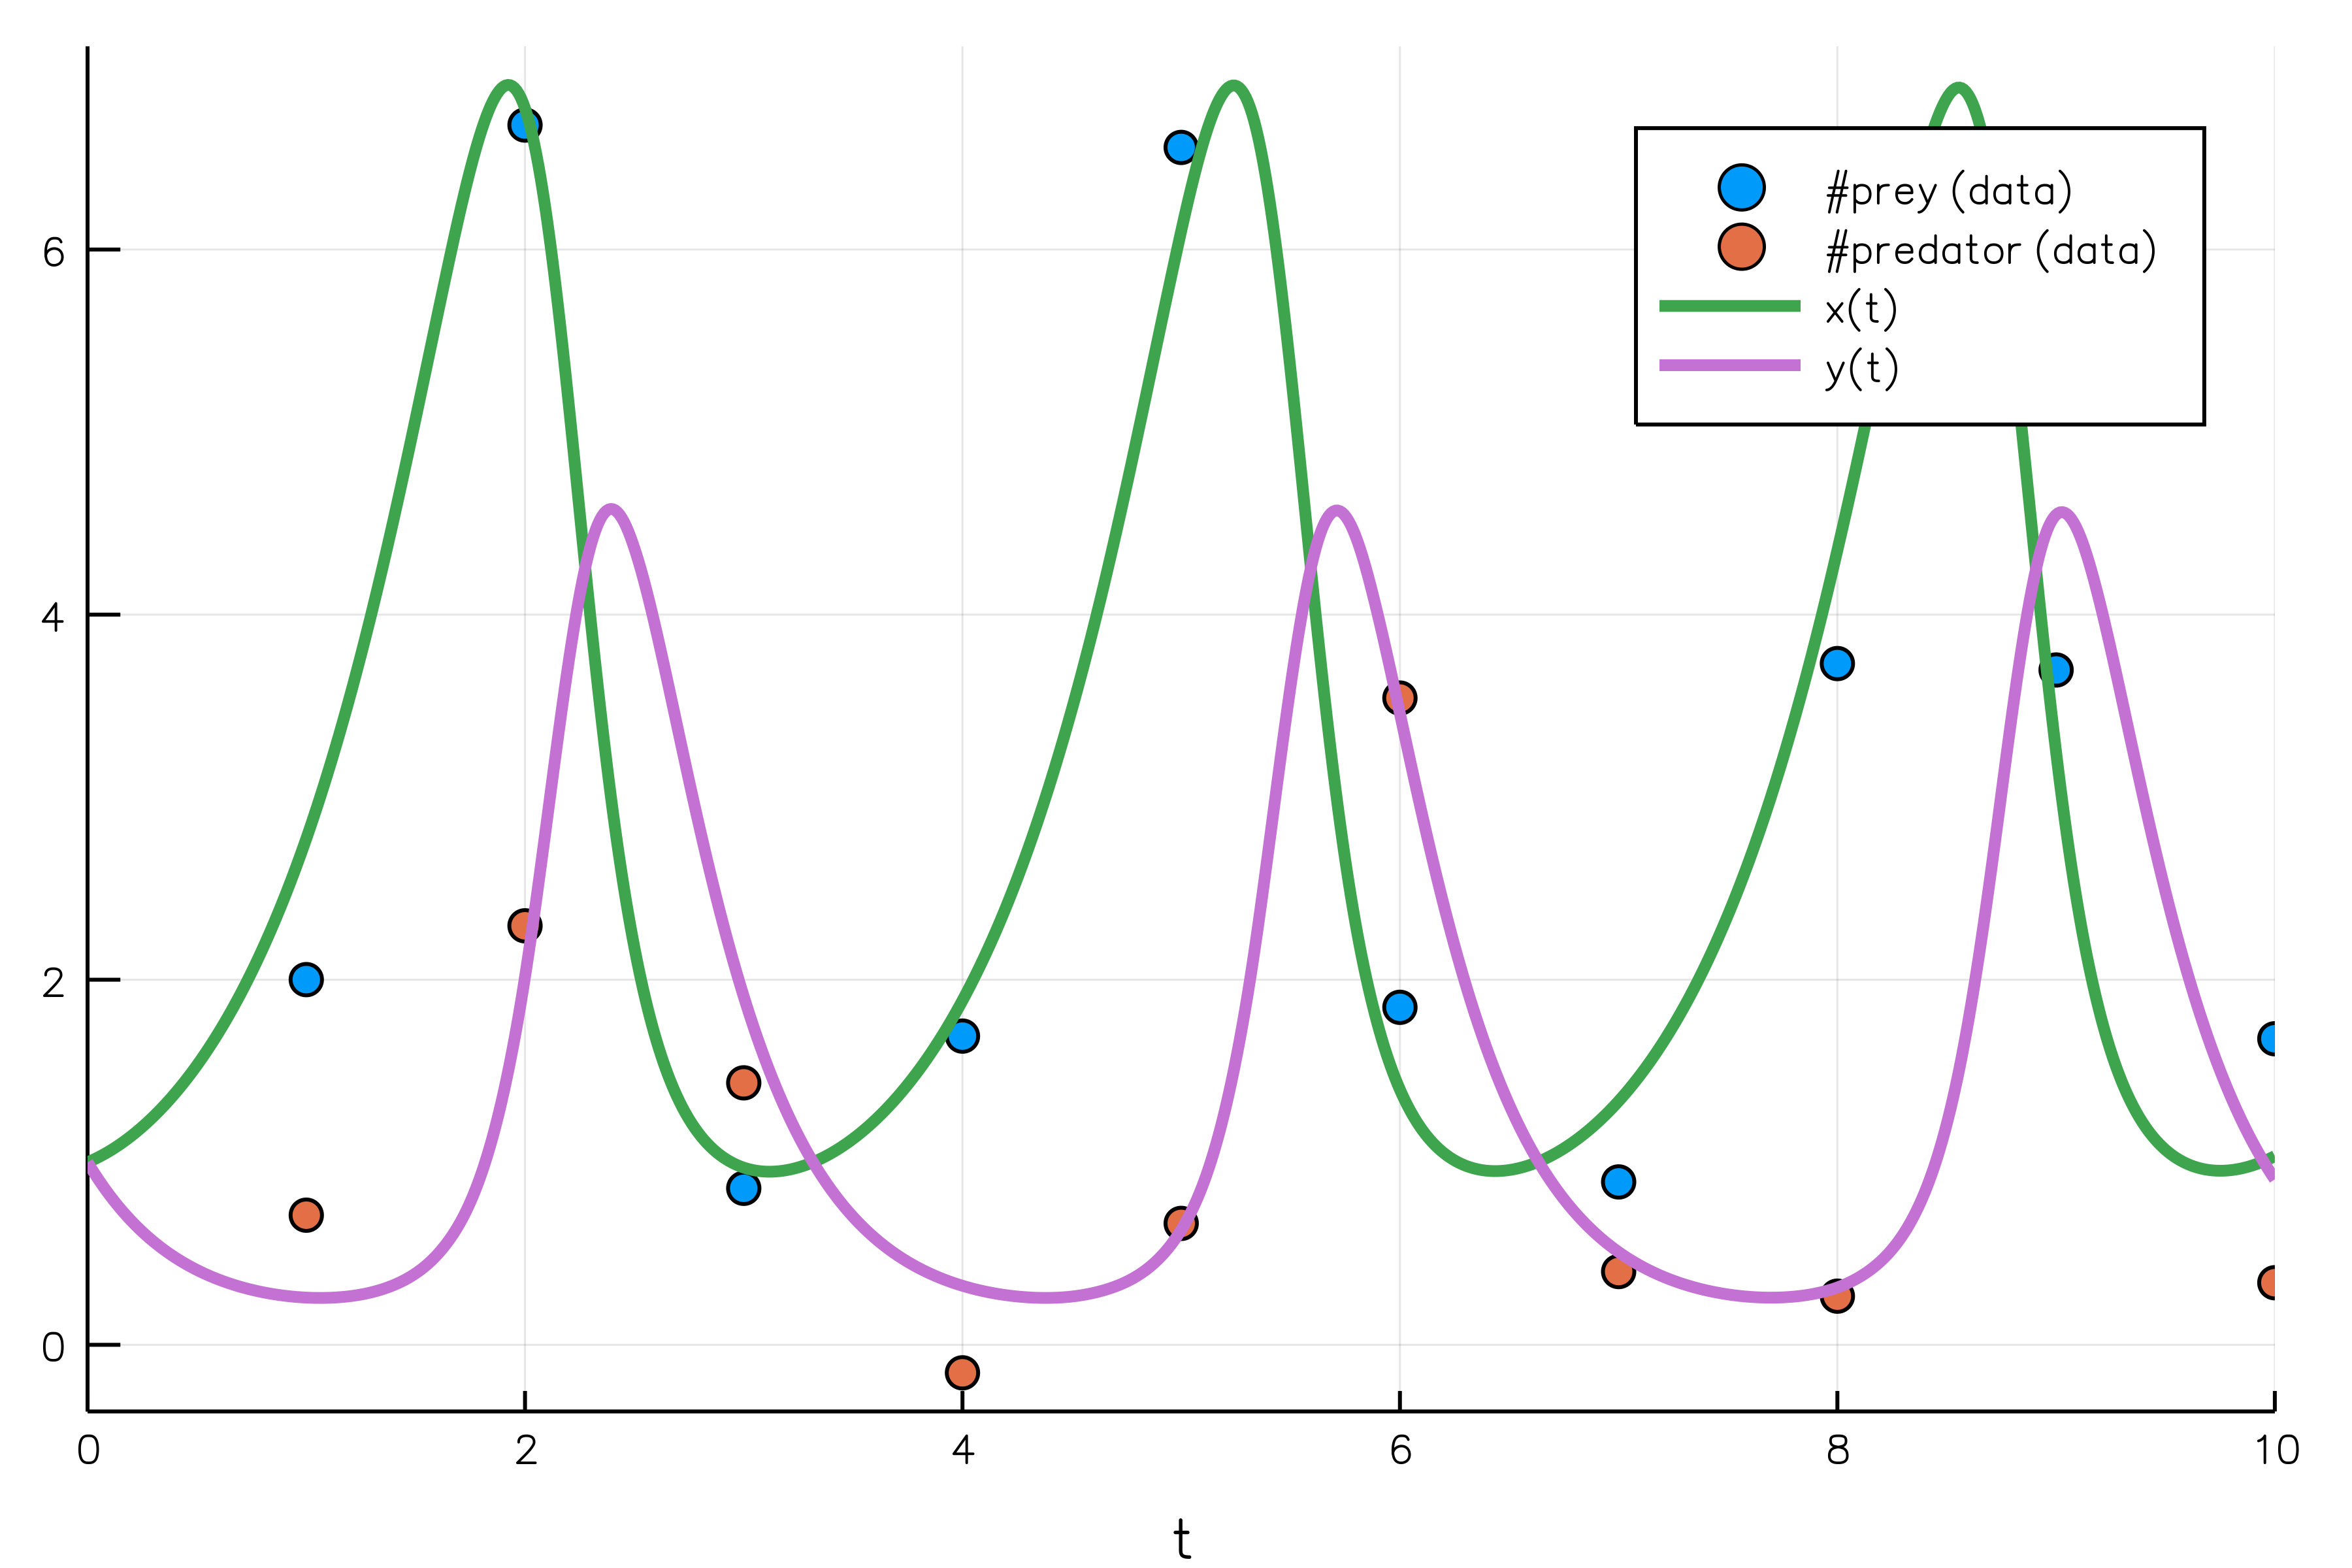

In [8]:
scatter(t, data[1,:], lab="#prey (data)")
scatter!(t, data[2,:], lab="#predator (data)")
plot!(sol)

In [13]:
priors = [Truncated(Normal(1.5,0.5),0.5,2.5),Truncated(Normal(1.2,0.5),0,2),Truncated(Normal(3.0,0.5),1,4),Truncated(Normal(1.0,0.5),0,2)]

4-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous},1}:
 Truncated(Distributions.Normal{Float64}(μ=1.5, σ=0.5), range=(0.5, 2.5))
 Truncated(Distributions.Normal{Float64}(μ=1.2, σ=0.5), range=(0.0, 2.0))
 Truncated(Distributions.Normal{Float64}(μ=3.0, σ=0.5), range=(1.0, 4.0))
 Truncated(Distributions.Normal{Float64}(μ=1.0, σ=0.5), range=(0.0, 2.0))

#### We use the uncertainity quantification plots to decide the tolerance to be passed.  


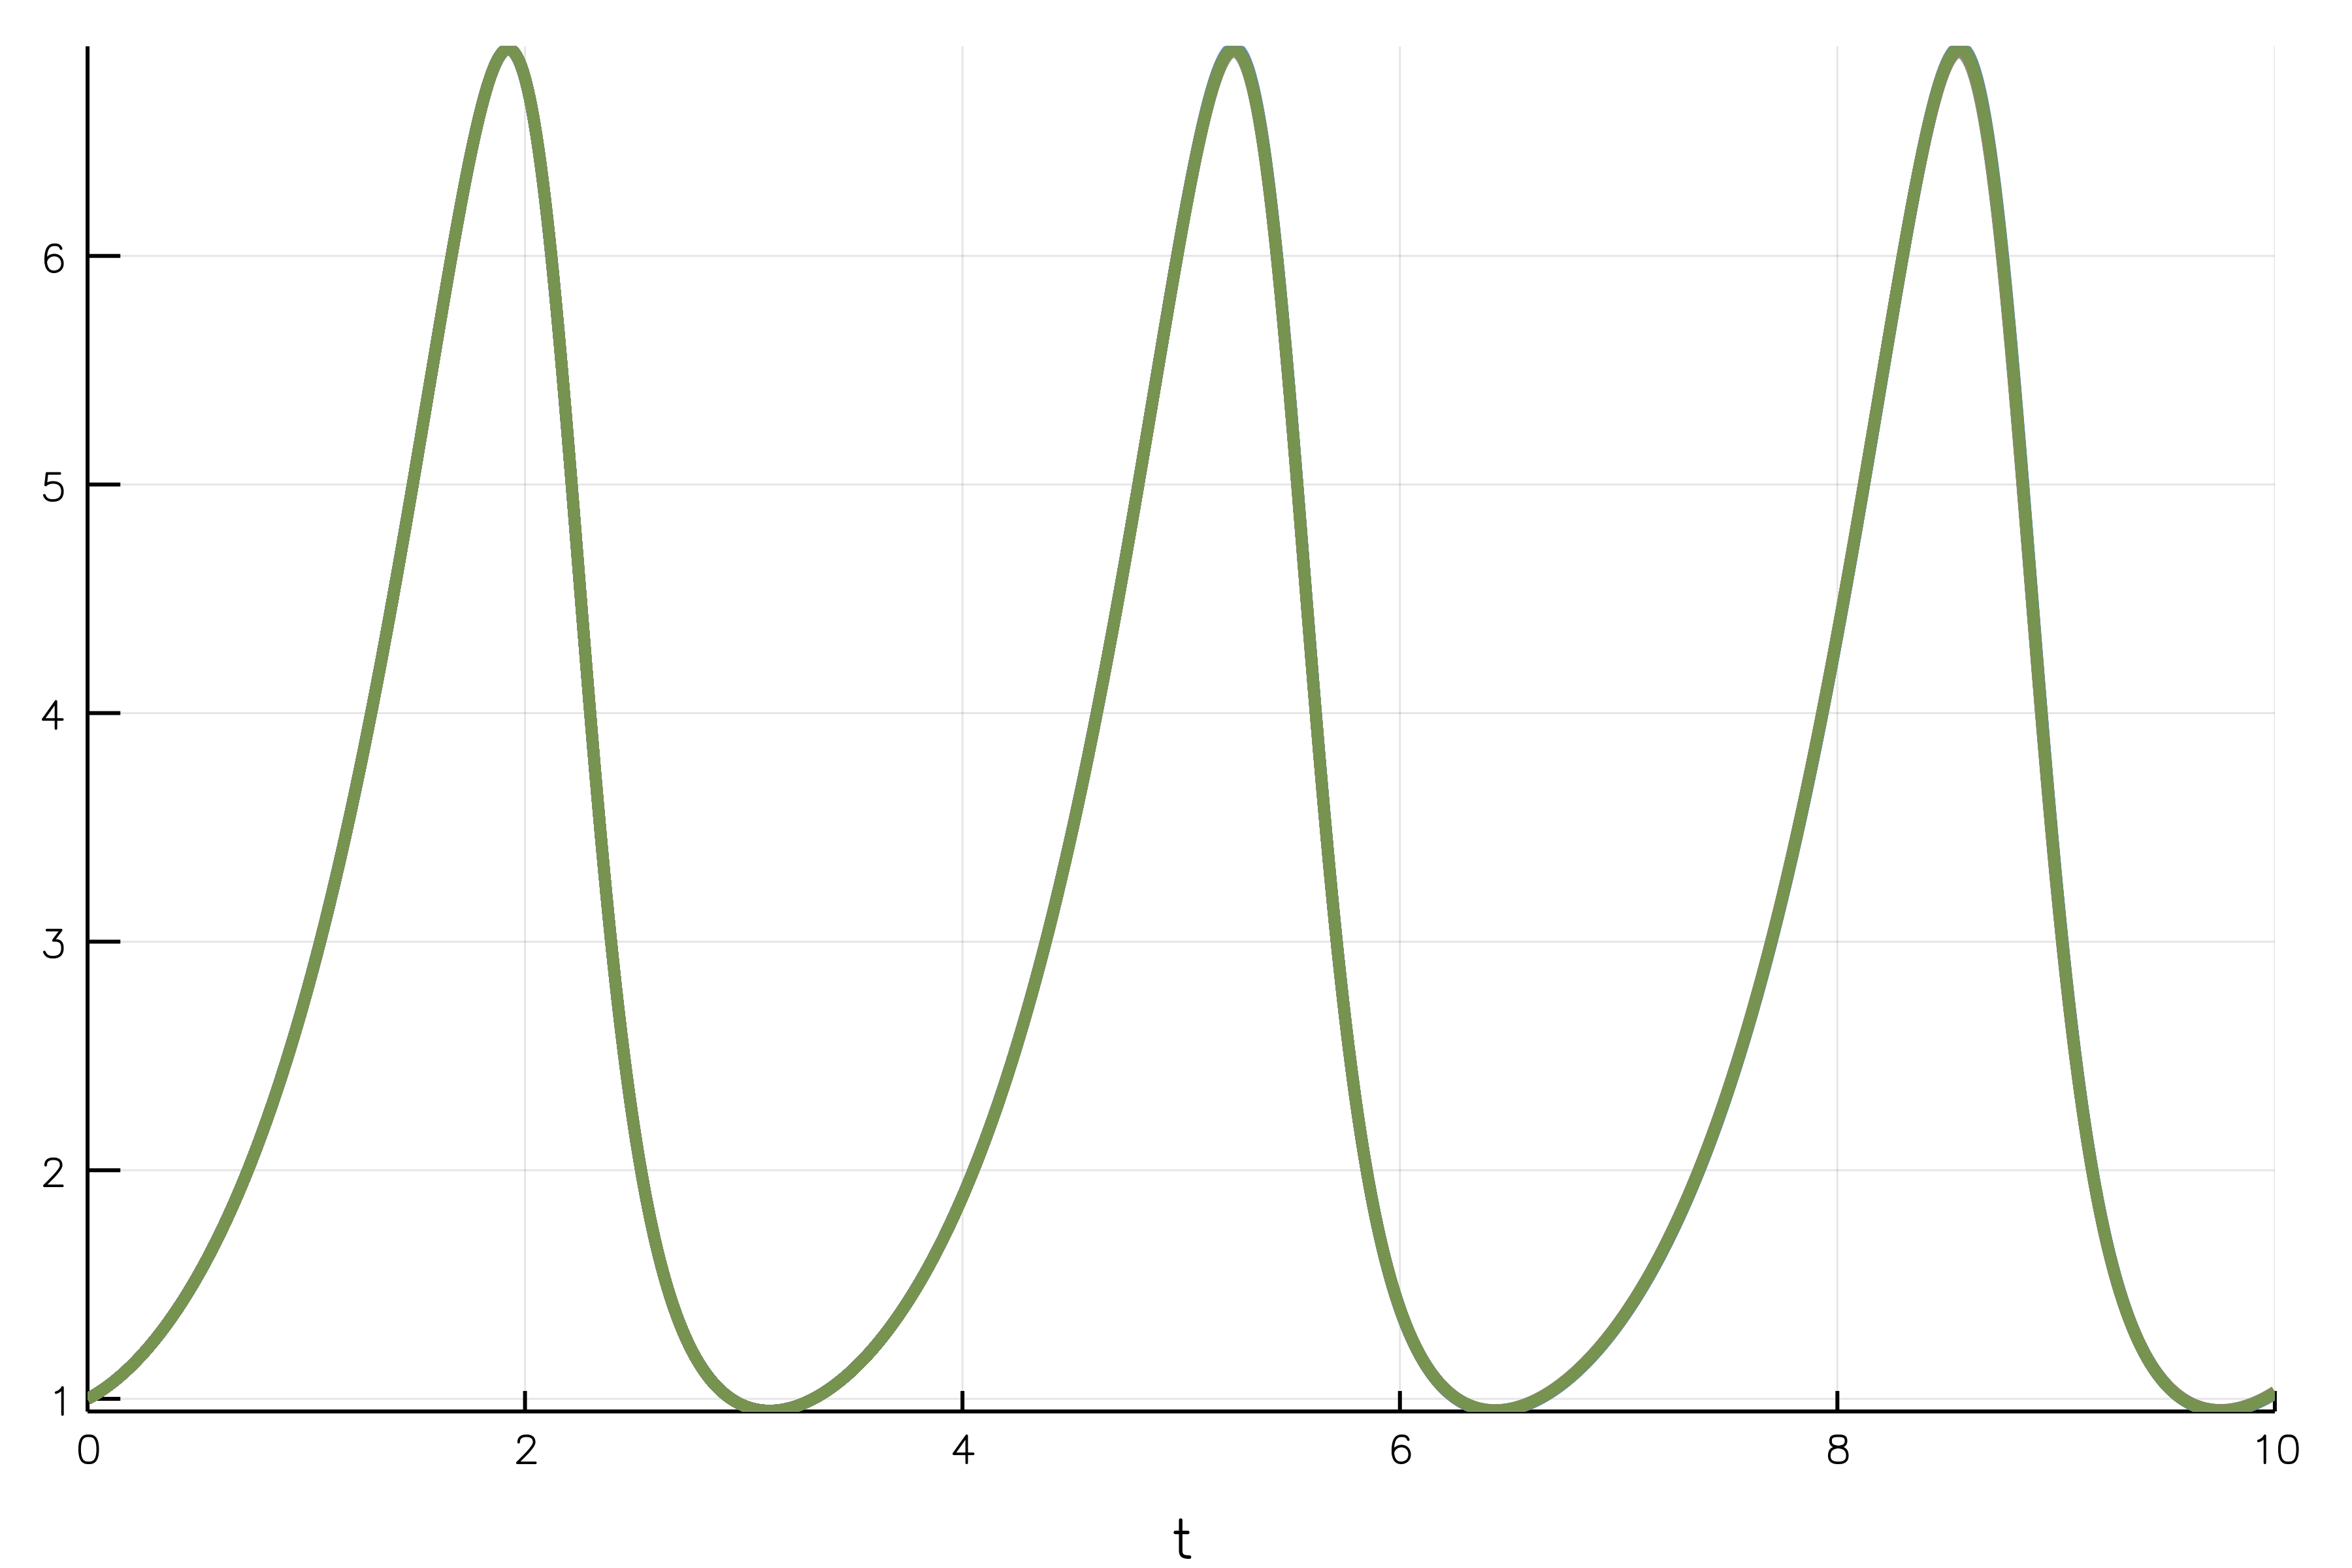

In [20]:
cb = AdaptiveProbIntsUncertainty(5)
monte_prob = MonteCarloProblem(prob)
sim = solve(monte_prob,Tsit5(),num_monte=100,callback=cb,reltol=1e-5,abstol=1e-5)
plot(sim,vars=(0,1),linealpha=0.4)

### Parameter estimation with Stan.jl backend

The solution converges for tolerance values lower than 1e-3, lower tolerance leads to better accuracy in result but is accompanied by longer warmup and sampling time, truncated normal priors are used for preventing Stan from stepping into negative values. 

In [19]:
@time bayesian_result_stan = stan_inference(prob,t,data,priors;num_samples=100,num_warmup=500,reltol=1e-5,abstol=1e-5,vars =(StanODEData(),InverseGamma(3,2)))


File /home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan will be updated.



--- Translating Stan model to C++ code ---
bin/stanc  /home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan --o=/home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.hpp
Model name=parameter_estimation_model_model
Input file=/home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan
Output file=/home/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.hpp

--- Linking C++ model ---
g++ -I src -I stan/src -isystem stan/lib/stan_math/ -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.62.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe   -lpthread  -O3 -o /home/vaibha

DiffEqBayes.StanModel{Int64,Mamba.Chains}(0, Object of type "Mamba.Chains"

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

[-0.333247 0.968174 … 2.92077 0.99204; 0.147285 0.992365 … 3.02731 0.980239; … ; 0.265482 0.998138 … 3.1118 1.04749; -0.655681 0.844556 … 3.0645 1.04025]

[0.608949 0.999401 … 3.02015 1.00355; -0.442726 0.984684 … 2.91089 0.968774; … ; -3.8938 0.956218 … 3.29073 1.01024; -1.26645 0.957763 … 3.11016 1.01608]

[-2.44238 0.996291 … 3.52333 1.21519; -1.44655 0.990781 … 3.36312 1.12691; … ; 0.00447506 0.997272 … 3.1572 1.07671; -1.77331 0.9924 … 3.34138 1.16571]

[-0.734092 0.926874 … 2.96557 0.962634; -1.63249 0.942814 … 2.89027 0.924255; … ; -6.39817 0.967459 … 3.08131 0.948585; -2.96193 0.976845 … 3.01622 1.00438])

In [11]:
Mamba.describe(bayesian_result_stan.chain_results)

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

Empirical Posterior Estimates:
                  Mean          SD        Naive SE       MCSE         ESS    
         lp__ -5.323158375  2.382742291 0.1191371145 0.1751610672 100.0000000
accept_stat__  0.919141913  0.127770982 0.0063885491 0.0159601323  64.0901803
   stepsize__  0.094288275  0.010539662 0.0005269831 0.0060774656   3.0075188
  treedepth__  4.752500000  0.841435550 0.0420717775 0.1285414978  42.8504119
 n_leapfrog__ 39.795000000 23.097005307 1.1548502653 4.3239671214  28.5329439
  divergent__  0.000000000  0.000000000 0.0000000000 0.0000000000         NaN
     energy__  8.551118200  3.102619940 0.1551309970 0.2378344530 100.0000000
     sigma1.1  0.638824997  0.162747137 0.0081373568 0.0146053273 100.0000000
     sigma1.2  0.576926487  0.200264895 0.0100132447 0.0106809726 100.0000000
       theta1  1.529288525  0.103698980 0.0051849490 0.0039268048 100.0000000
       theta2  1.025077063  

Plots of the chains generated to show convergence. 

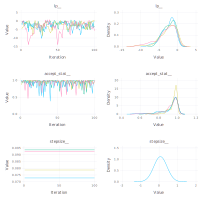

Press ENTER to draw next plot
STDIN> 


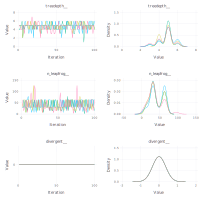

Press ENTER to draw next plot
STDIN> 


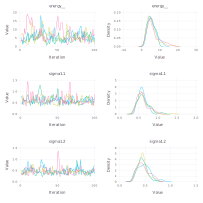

Press ENTER to draw next plot
STDIN> 


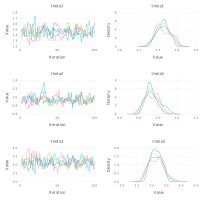

Press ENTER to draw next plot
STDIN> 


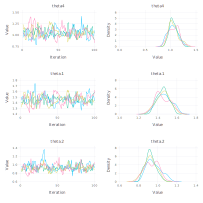

Press ENTER to draw next plot
STDIN> 


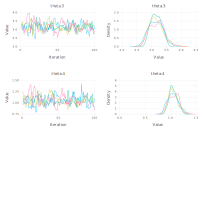

In [13]:
plot_chain(bayesian_result_stan)

### Parameter estimation with Turing.jl backend

In [14]:
@time bayesian_result_turing = turing_inference(prob,Tsit5(),t,data,priors;num_samples=500)

[HMC] Sampling...  0%  ETA: 3:21:21
  ϵ:         0.02
  α:         0.9707629214078632
[HMC] Sampling... 33%  ETA: 0:00:52
  ϵ:         0.02
  α:         0.9170758602638979
[HMC] Sampling... 62%  ETA: 0:00:16
  ϵ:         0.02
  α:         0.4656280433643565
[HMC] Sampling... 91%  ETA: 0:00:03
  ϵ:         0.02
  α:         0.9440401697779226
cond:  [1.0, 1.0, 1.0, 1.0, 1.0]

[HMC] Finished with
  Running time        = 27.60854443199999;
  Accept rate         = 0.846;
  #lf / sample        = 3.992;
  #evals / sample     = 3.996;
  pre-cond. diag mat  = [1.0, 1.0, 1.0, 1.0, 1.0].


[HMC] Sampling...100% Time: 0:00:28


 33.339090 seconds (24.01 M allocations: 2.704 GiB, 3.45% gc time)


Object of type "Turing.Chain"

Iterations = 1:500
Thinning interval = 1
Chains = 1
Samples per chain = 500

[1.15827 2.12756 … -47.2338 0.02; 1.16667 2.11223 … -48.2589 0.02; … ; 1.33045 0.708013 … -24.3004 0.02; 1.33045 0.708013 … -24.3004 0.02]

The chains seem to have not converged and require longer chains but there isn't anyway to pass warmup samples it to Turing.jl's HMC sampler which has been used as the sampler in the implementation.

In [15]:
Mamba.describe(bayesian_result_turing)

Iterations = 1:500
Thinning interval = 1
Chains = 1
Samples per chain = 500

Empirical Posterior Estimates:
             Mean                 SD                       Naive SE               MCSE        ESS   
 theta4   1.082276853 0.099035822770014853011489 0.00442901663842749492711048 0.033868858   8.550343
      σ   0.636859287 0.275906172254198611692999 0.01233889913144309118109287 0.078647703  12.306959
 theta2   0.948746716 0.092781208889136809747633 0.00414930180221435331022750 0.013706499  45.821256
 theta1   1.434560896 0.076531279169960372832371 0.00342258285258090167932354 0.025790395   8.805661
 lf_num   3.992000000 0.178885438199983204388133 0.00800000000000000016653345 0.008000000 500.000000
elapsed   0.055390343 1.058668136692086481076558 0.04734507838513089122978172 0.048286926 480.684997
 theta3   3.200721684 0.246723997972156688929246 0.01103383262292525167358459 0.090727250   7.395155
     lp -21.354770969 4.328098851914085720693492 0.19355846492437381312079481 1.0569

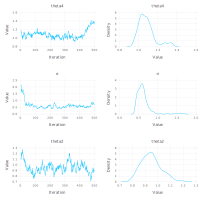

Press ENTER to draw next plot
STDIN> 


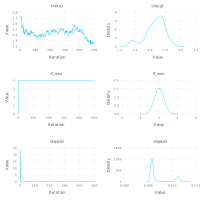

Press ENTER to draw next plot
STDIN> 


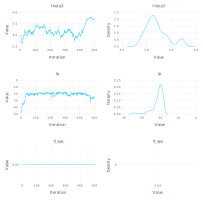

In [16]:
u = Mamba.plot(bayesian_result_turing)
Mamba.draw(u)

### Parameter estimation using DynamicHMC.jl backend.

In [14]:
@time bayesian_result_dynamic = dynamichmc_inference(prob, data, priors, t, [bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, )])

197.097564 seconds (230.46 M allocations: 23.945 GiB, 2.86% gc time)


(([1.51878, 1.51869, 1.51875, 1.51872, 1.51866, 1.51873, 1.51869, 1.51873, 1.51874, 1.51874  …  1.51905, 1.51906, 1.51905, 1.51903, 1.51903, 1.51904, 1.51911, 1.51911, 1.51909, 1.51916], [0.976555, 0.976638, 0.976587, 0.976603, 0.976642, 0.976599, 0.97663, 0.976575, 0.976537, 0.976539  …  0.976612, 0.976604, 0.976628, 0.976631, 0.97663, 0.976622, 0.976551, 0.976559, 0.976578, 0.976523], [2.88461, 2.88476, 2.88466, 2.88468, 2.88473, 2.88463, 2.88468, 2.88458, 2.88449, 2.88448  …  2.88408, 2.88407, 2.88407, 2.88408, 2.88408, 2.88408, 2.88392, 2.88391, 2.88397, 2.88386], [0.961225, 0.961334, 0.961277, 0.961288, 0.961325, 0.961258, 0.961294, 0.961228, 0.961185, 0.961179  …  0.960881, 0.960865, 0.960872, 0.960891, 0.960889, 0.960892, 0.960788, 0.960777, 0.960812, 0.960732]), DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}[DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}([0.417907, -0.0237243, 1.05939, -0.0395463], -23160.2, 5, MaxDepth, 0.709677, 31), DynamicHMC.NUTS_Transition{Arr

In [15]:
DynamicHMC.NUTS_statistics(bayesian_result_dynamic[2]),bayesian_result_dynamic[3],mean(bayesian_result_dynamic[1][1]),mean(bayesian_result_dynamic[1][2]),mean(bayesian_result_dynamic[1][3]),mean(bayesian_result_dynamic[1][4])

(Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.92, min/25%/median/75%/max: 0.06 1.0 1.0 1.0 1.0
  termination: MaxDepth => 100%
  depth: 5 => 100%
, NUTS sampler in 4 dimensions
  stepsize (ϵ) ≈ 0.00558
  maximum depth = 5
  Gaussian kinetic energy, √diag(M⁻¹): [0.00030316, 0.00038132, 0.000276963, 0.000548693]
, 1.5190560184763253, 0.976353773943948, 2.8837574748724175, 0.960718122311877)


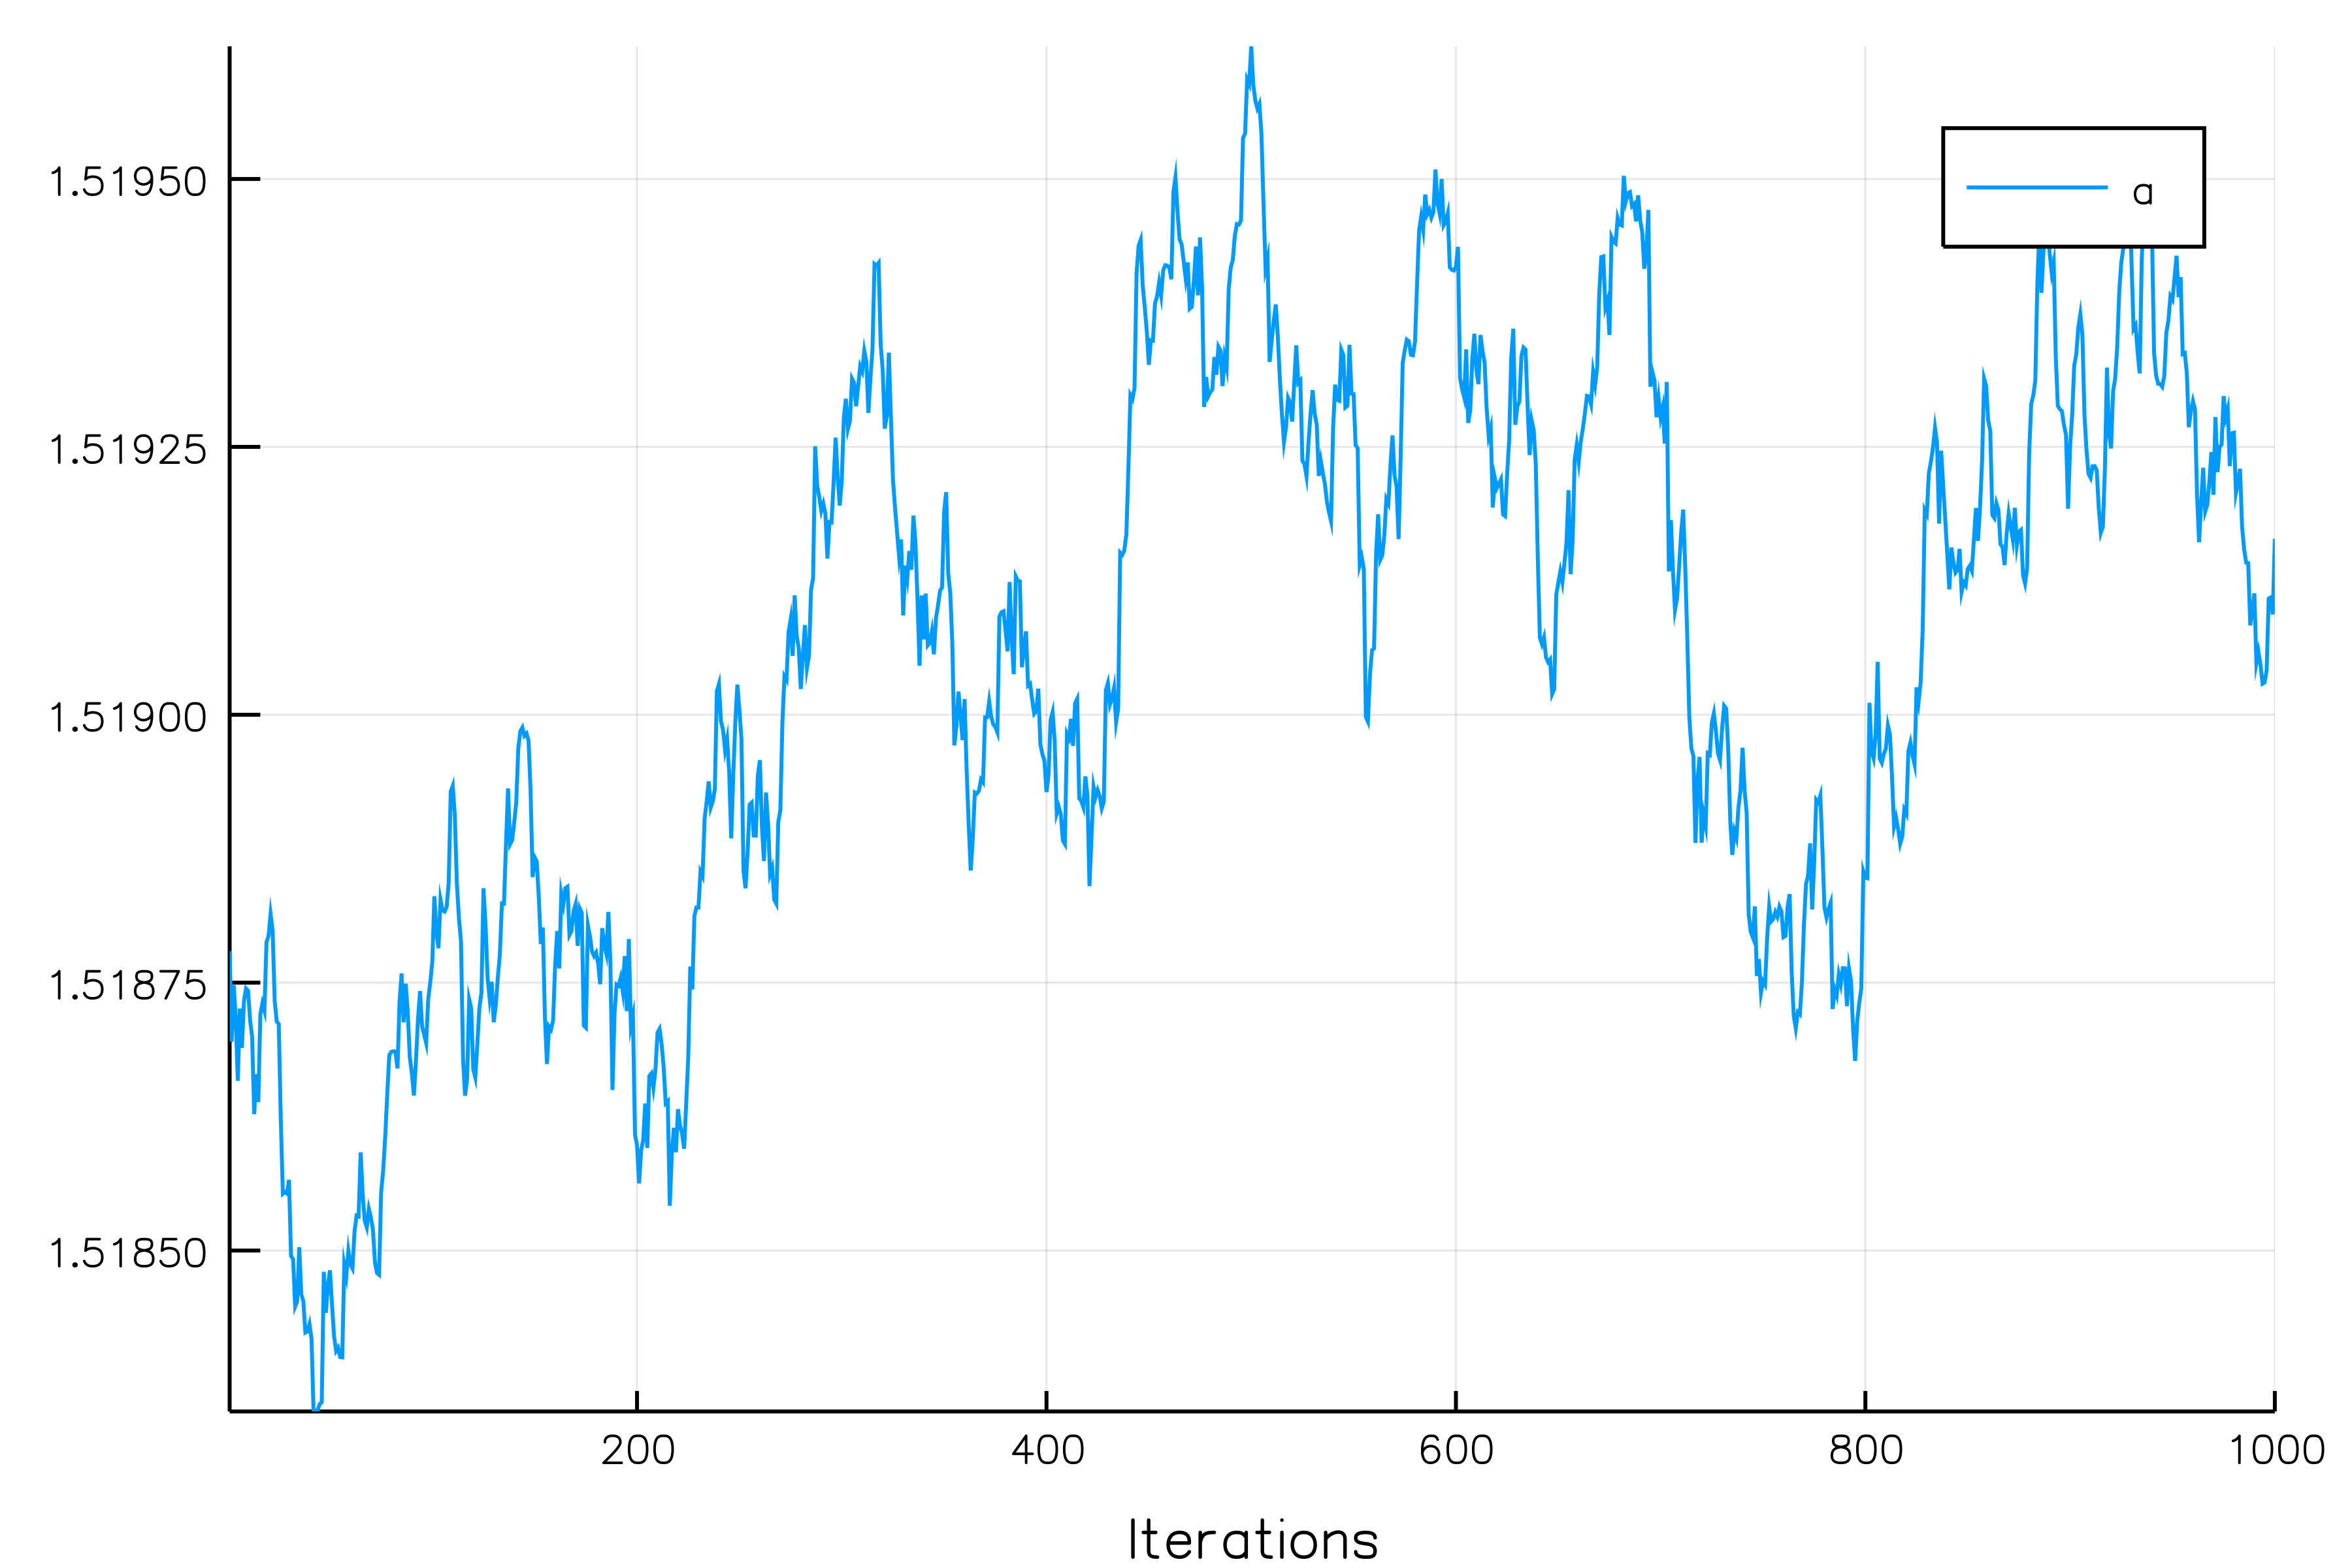

In [20]:
plot(bayesian_result_dynamic[1][1], label="a", xlab="Iterations")


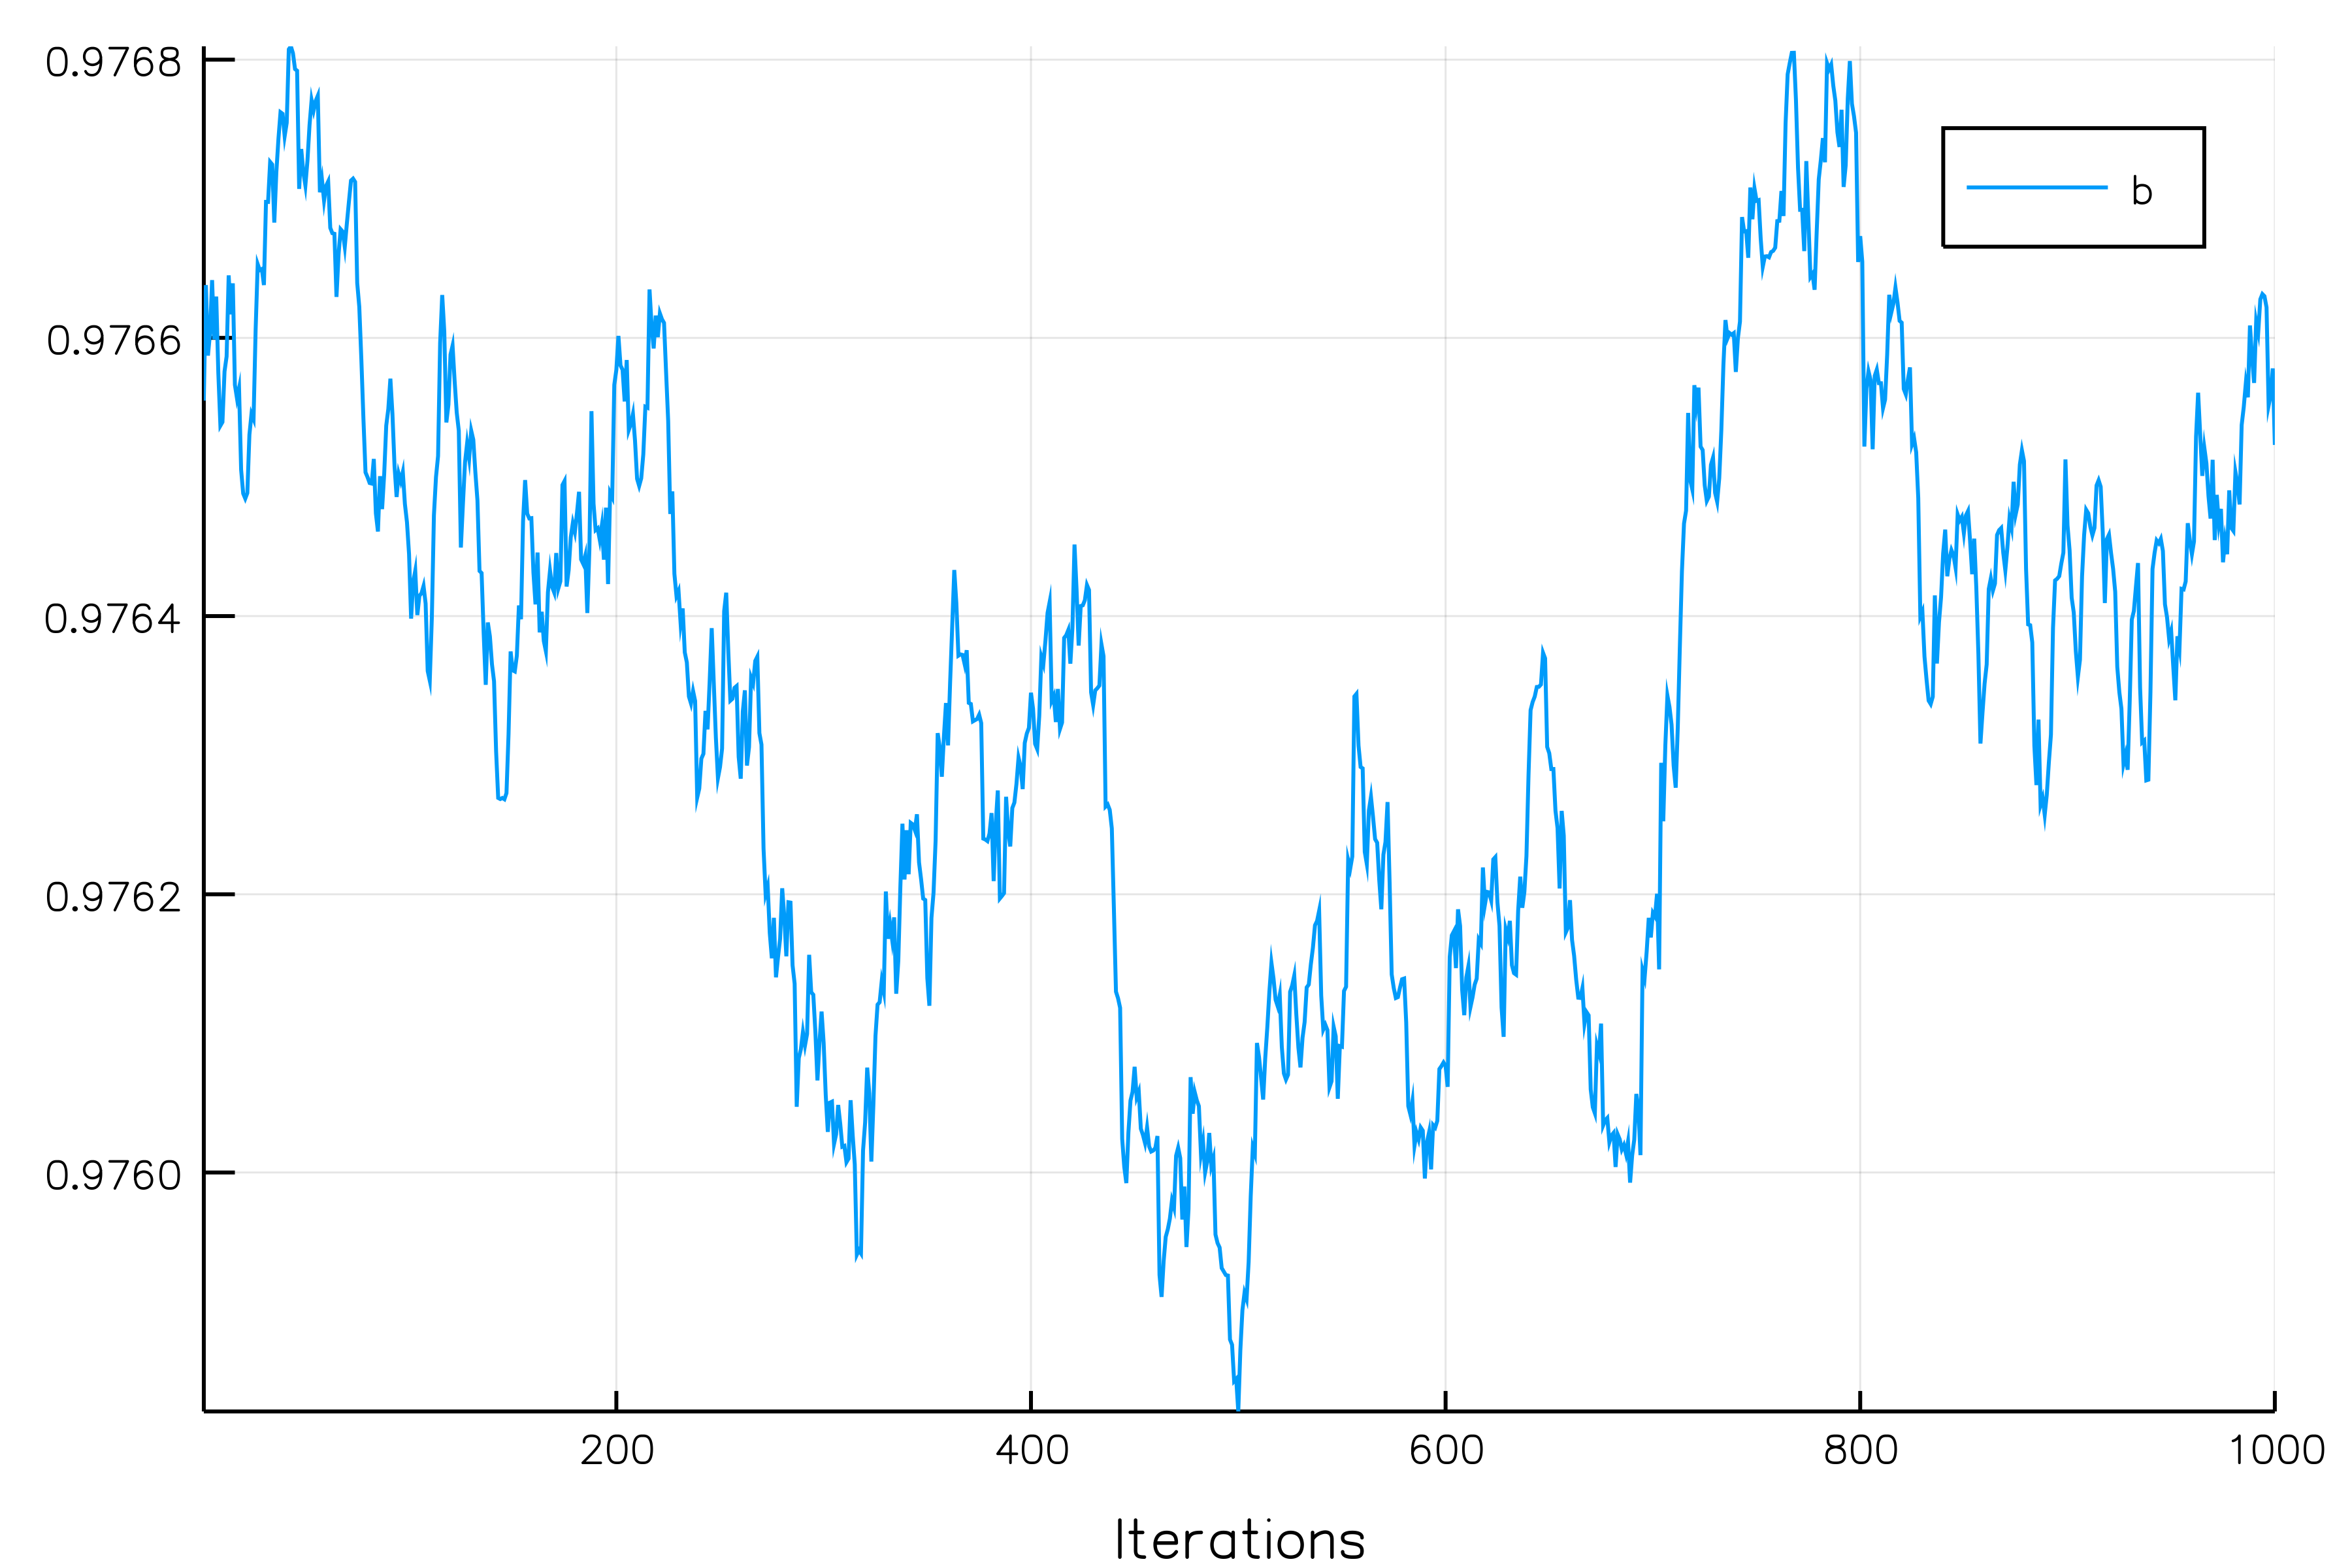

In [22]:
plot(bayesian_result_dynamic[1][2], label="b", xlab="Iterations")


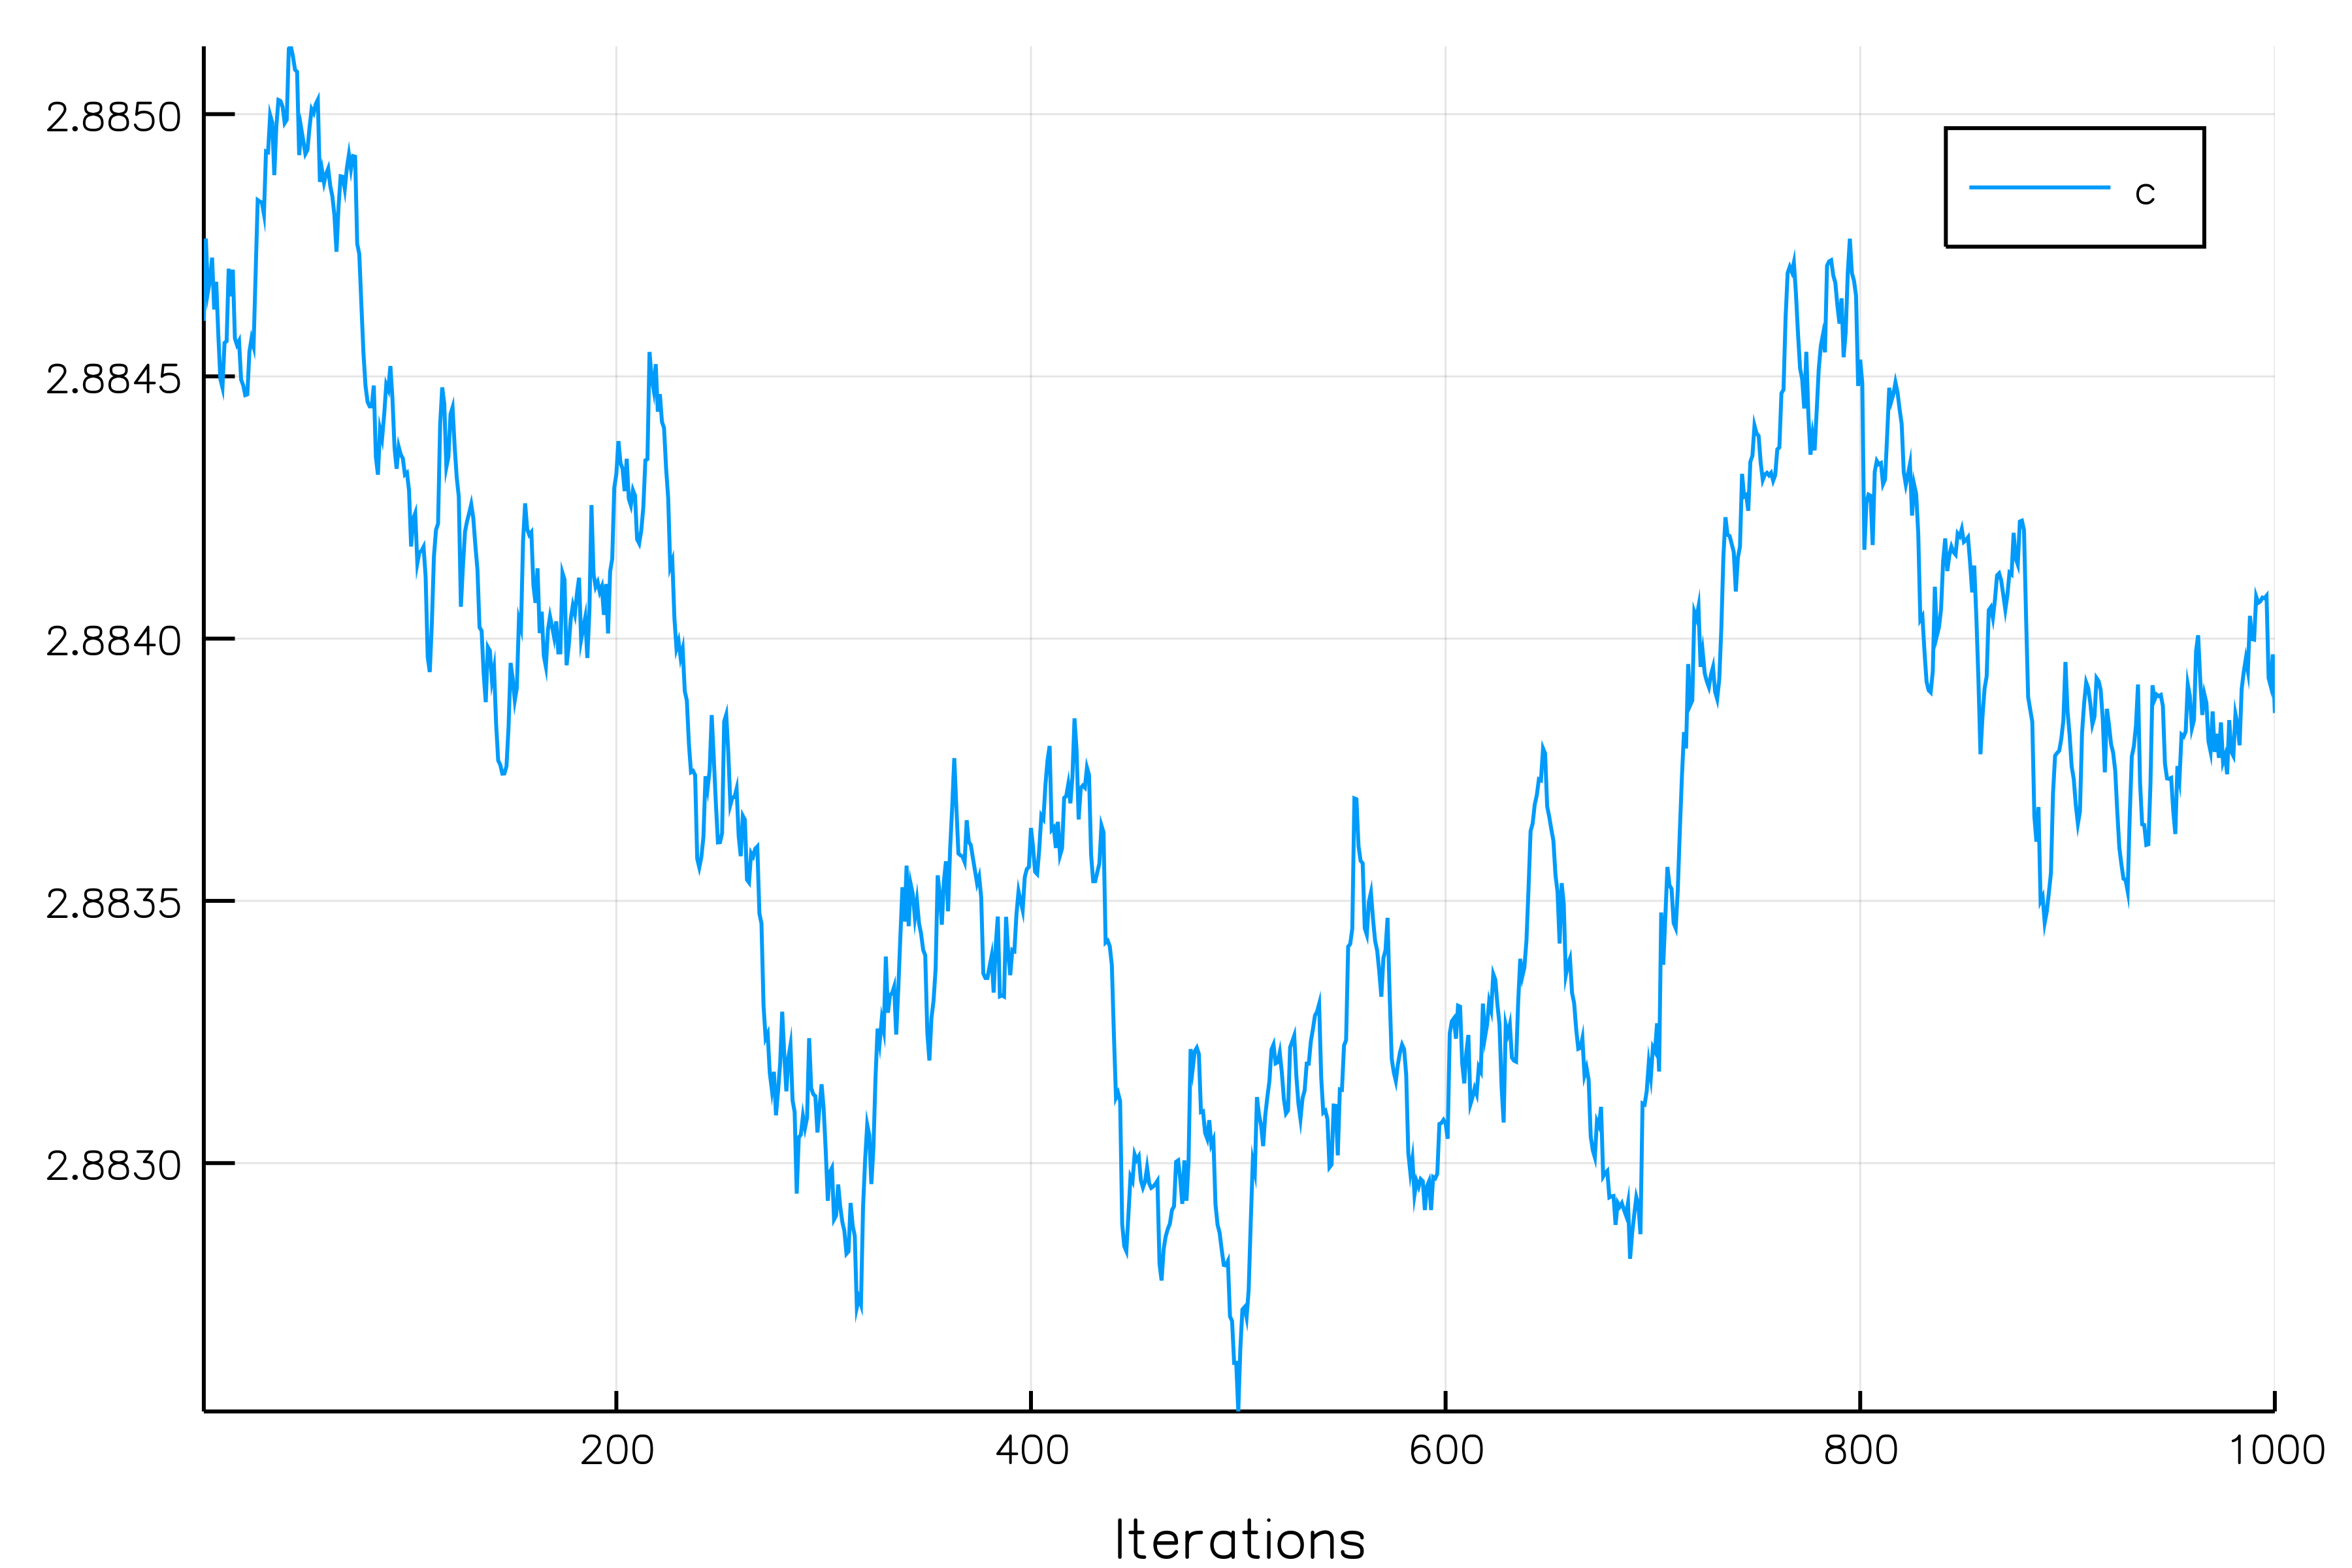

In [23]:
plot(bayesian_result_dynamic[1][3], label="c", xlab="Iterations")


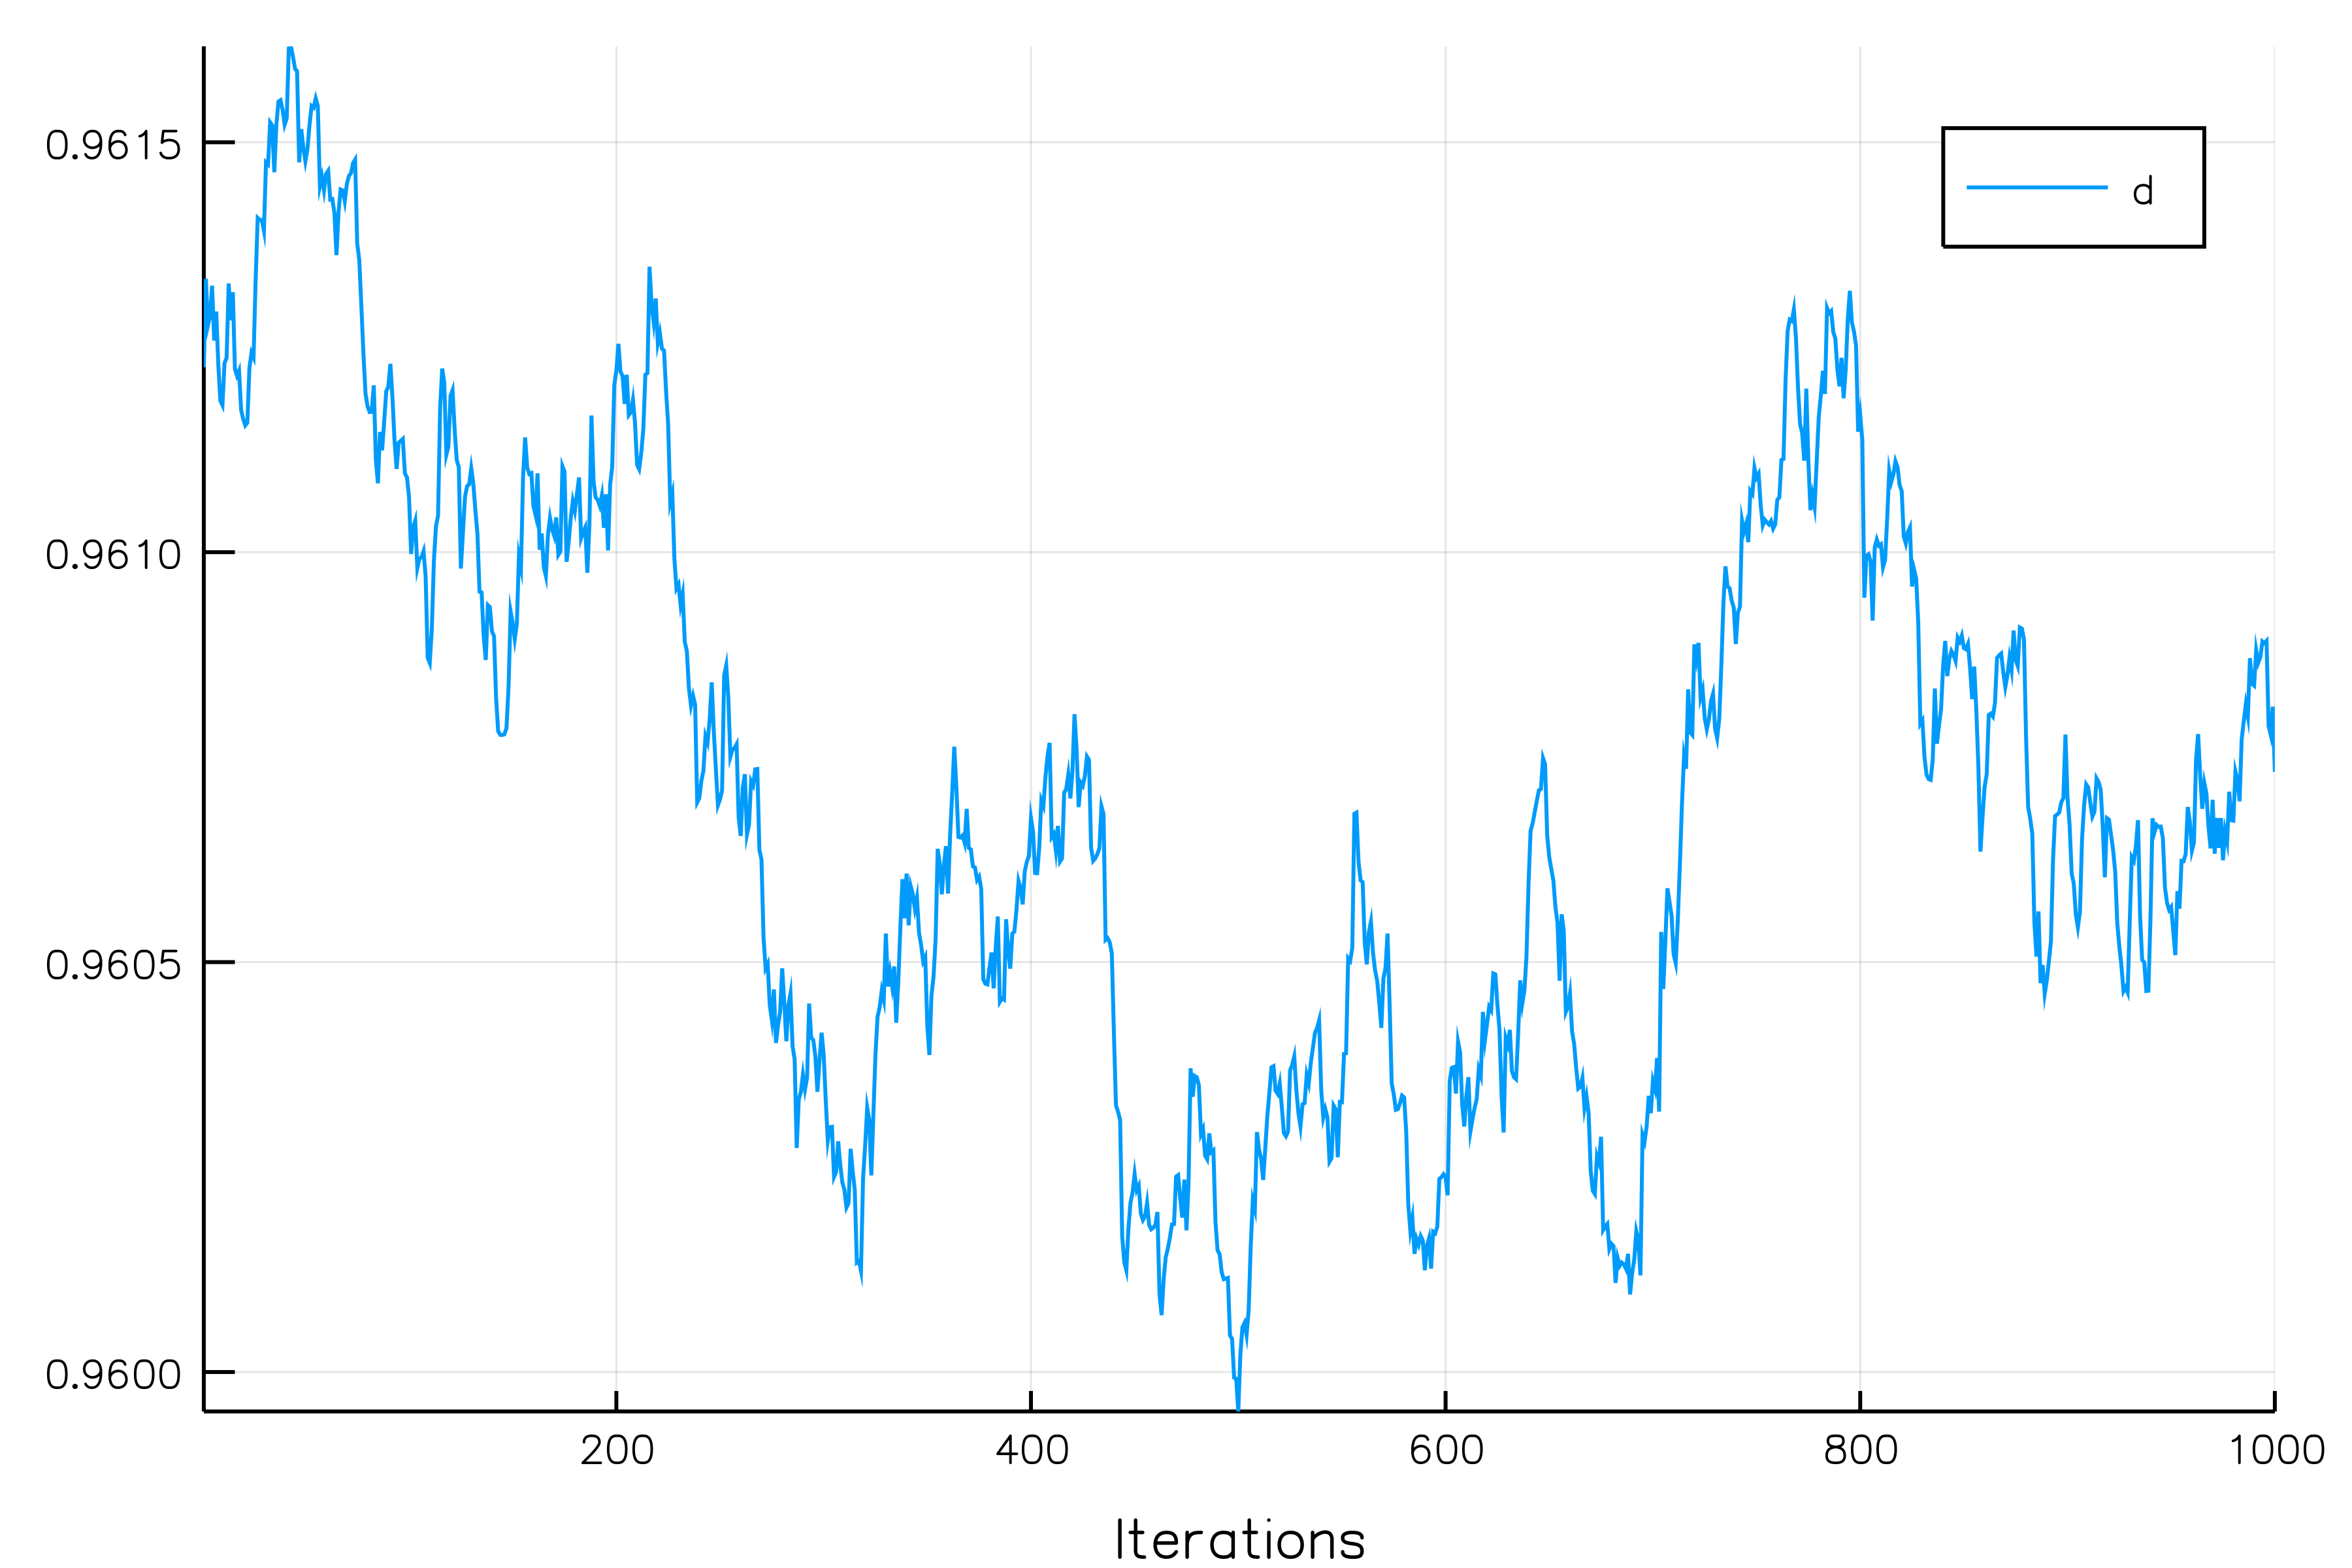

In [24]:
plot(bayesian_result_dynamic[1][4], label="d", xlab="Iterations")

## Conclusion

Lotka-Volterra Equation is a "predator-prey" model, it models population of two species in which one is the predator (wolf) and the other is the prey (rabbit). It depicts a cyclic behaviour, which is also seen in its Uncertainity Quantification Plots. This behaviour makes it easy to estimate even at very high tolerance values (1e-3).


In case of Stan.jl backend we obtain quite accurate values by setting sufficiently low tolerance at 1e-5 and passing 500 warmup samples, because as evident from the plots as it didn't converge before it which was observed from multiple runs, which ensures both high accuracy within 1.84 minutes, 1.7 minutes for warmup sampling and 14 seconds for sampling. Decreasing the tolerance leads to more accurate results but at the cost of significant increase in time taken. 

Turing.jl backend implementation doesn't seem to have converged, inability to pass warmup samples is one of the drawbacks, the results obtained are quite accurate and it recorded 33.33 seconds.

Using DynamicHMC.jl as the backend gives good accuracy and takes 197 seconds but the exploration of the domain seems to be more constrained as compared to other backends as evident from the plots which is due to the lower stepsize, this can be adjusted by passing the kwarg ϵ.